## CHALLENGE RAG


**Objetivo:**

Se buscar generar una aplicacion que responda consultas sobre historias para niños.

Completar en el notebook los distintos apartados para desarrollar una solucion tipo RAG sobre los documentos brindados.


**Contexto**:

Cada documento contiene una historia que no tiene relacion con las demas.


**Comportamiento**:


Las respuestas tienen que tener las siguientes caracteristicas:

- Responder de manera amigable y con tono entusiasta, como si se le hablara a un niño.
- Responder en maximo 3 oraciones.
- Agregar emojis a la respuesta.
- Ante la misma pregunta se busca una respuesta lo mas similar posible para cada interaccion.
- Responder siempre en español, sin importar en que idioma se haga la pregunta.
- Solo utilizar el contenido de las historias para responder sobre las preguntas del usuario.


La aplicacion no tendra historial de conversaciones ni verificacion de respuestas.

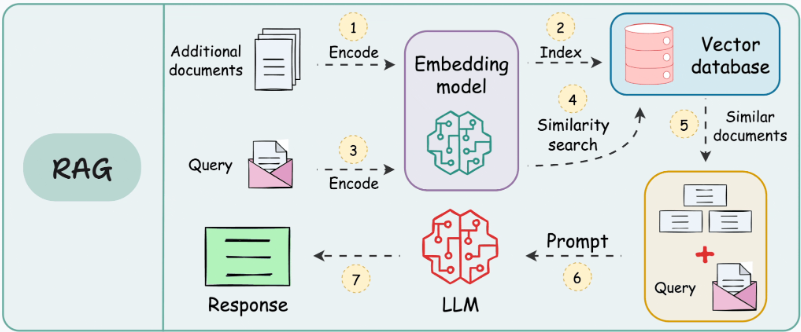

## Environment setup

In [ ]:
# Importar librerias
# Cargar las API keys necesarias
# Hacer las conexiones necesarias

In [2]:
import os
import json
import chromadb
import cohere
from dotenv import load_dotenv
import uuid


load_dotenv() 

api_key = os.getenv("COHERE_API_KEY")
co = cohere.ClientV2()
chroma_client = chromadb.Client()



In [3]:
from pypdf import PdfReader
# Lectura y extraccion de contenido de pdf hacia un objeto en python

reader = PdfReader('Historias.pdf')

#print(len(reader.pages))

pdf_obj = reader.pages[0]

pdf_obj_ = reader.pages[1]

pdf_obj_3 = reader.pages[2]

#print(pdf_obj_3.extract_text())

## Carga de documentos


In [ ]:
# Cargar los documentos brindados y ejecutar el chuncking de los mismos

# Especificar en comentarios porque fueron por esa tecnica de chunck y ese chunck size

In [4]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=0)
chunc_1 = text_splitter.split_text(pdf_obj.extract_text())
chunc_2 = text_splitter.split_text(pdf_obj_.extract_text())
chunc_3 = text_splitter.split_text(pdf_obj_3.extract_text())

chuncs = chunc_1 + chunc_2 + chunc_3

print(f"Tamaño de chunc_1: {len(chunc_1)}")
print(f"Tamaño de chunc_2: {len(chunc_2)}")
print(f"Tamaño de chunc_3: {len(chunc_3)}")


Tamaño de chunc_1: 6
Tamaño de chunc_2: 6
Tamaño de chunc_3: 2


In [89]:
# recomendacion para chunking, usar el metodo RecursiveCharacterTextSplitter de Langchain, es de lo mas utilizado

El contenido del pdf son de tres historias y las paginas que obtiene la libreria pypdf son 3 tambien, por ende me parecio oportuno.
separar en 3 los chuncking y utilice el metodo de RecursiveCharacterTextSplitter porque en la documentacion 
especifica que es mejor para poder guardar parrafos enteros. 
Utilice la medida 500 en chunk_size ya que parece que el modelo tiene un mejor funcionamiento con un maximo de 512 tokens.
Con esta medida y chunk_overlap en valor 0, me costate que los tamaños de los chuncks coincidieran lo maximo posible, pudiendo abarcar lo mas que se pueda de informacion sobre las historias repartidas en 2 1/3 del documento pdf. 

## Vector store


In [8]:
# Conexion a la base de datos vectorial
# Carga de datos en la base

# Porque eligieron ese algoritmo de embeddings?

collection = chroma_client.create_collection(name="db_historias")

In [6]:


model_multi = "embed-multilingual-v3.0"
all_mini = "all-MiniLM-L6-v2"

def convertir_embeddings(texto):
    response = co.embed(
        texts=texto,
        model=model_multi,
        input_type="search_document",
        embedding_types=["float"]
    )
    
    return response.embeddings.float_



def convertir_ids(chunks):
    return [f"id_{uuid.uuid4()}" for i in range(len(chunks))]

In [7]:

chunc_embeddings = convertir_embeddings(chuncs)
ids = convertir_ids(chuncs)
collection.add(
                documents=chuncs,
                ids=ids,
                embeddings=chunc_embeddings)

# print(f"Tamaño de chuncs: {len(chuncs)}")
# print(f"Tamaño de ids: {len(ids)}")
# print(f"Tamaño de embeddings: {len(chunc_embeddings)}")

[[-0.041748047, -0.015419006, -0.014251709, 0.02192688, -0.074523926, -0.109375, -0.033569336, 0.0126953125, -0.022857666, 0.008666992, 0.048919678, -0.052246094, 0.007896423, -0.021438599, 0.012252808, -0.007045746, 0.012397766, 0.007484436, 0.01828003, 0.0035552979, -0.0015621185, 0.012588501, 0.009864807, -0.02708435, -0.0064086914, 0.00381279, 0.02960205, 0.007888794, 0.011062622, -0.009063721, -0.021255493, 0.0007853508, 0.0075912476, 0.05908203, -0.04574585, -0.015716553, -0.015899658, -0.027267456, -0.0072288513, 0.01725769, -0.026931763, 0.025985718, 0.0134887695, 0.02545166, -0.014320374, 0.02017212, -0.0058021545, -0.0110321045, 0.028030396, -0.026733398, 0.035125732, 0.06951904, -0.0423584, -0.03668213, -0.03164673, 0.058380127, 0.012413025, -0.06524658, 0.008491516, -0.024536133, -0.009819031, -0.060577393, -0.058258057, -0.01586914, -0.07330322, -0.012496948, -0.002090454, -0.017623901, 0.03665161, 0.025634766, -0.03286743, 0.035125732, 0.050323486, -0.010482788, -0.053924

NameError: name 'collection' is not defined

Bueno, elegi el modelo de "embed-multilingual-v3.0" debido que en los ejercicios anteriores pruebas fue el mas efectivo y ademas maneja el plus de poder ingresar nueva informacion hacia la base vectoral, sin discriminar por el idioma, pudiendo apliar el dataset en el que se base el modelo. A su vez, en su documentacion recalca que el modelo está optimizado para tareas de búsqueda semántica, lo que me parecio una buena caracteristica para el challenge.

Luego genere dos funciones que me ayudan en el proceso de carga de los chuncks procesados como embeddigns hacia la base vectoral. 
Despues, en el agregado a la base, implemente la suma de los chuncks (chuncs = chunc_1 + chunc_2 + chunc_3) para poder manejar la carga de una sola vez, con sus respectivos ids y verificando que la carga sea pareja, es decir, que el tamaño de documents, ids y embeddigns sean parejos y no represente problemas al momento de la superacion de tokens. 

## Prompt

In [13]:
# Incluir personalidad y especificaciones de las respuestas.
# Incluir la pregunta del usuario
# Incluir la informacion devuelta por la base de datos



def modelo_traductor(pregunta):
    response_ = co.chat(
        model="command-r-plus",
        messages=[{"role":"system","content":f"""Eres experto en traducion de idiomas al Español.
                   Tu respuesta debe ser la traducion del texto en Español. Si el idioma de la pregunta es español, no modifiques la pregunta"""},
                  {"role":"user", "content":f"{pregunta}"}]
    )

    return response_.message.content[0].text


def chat_response(contexto,consulta):
    
    model_ = "command-r-plus"
    prompt = co.chat(
        model=model_,
        messages=[{"role":"system","content":f"""Eres un experto en comprension de textos y relator de historias. 
                   Te proporcionare un contexto para tengas un mejor panorama: {contexto}.
                   Tu tarea es moldear la consulta junto al contexto."""},
                  {"role":"user", "content":f"{consulta}"}]
    )

    modelo_1 = prompt.message.content[0].text

    emojin = co.chat(
            model = "command-r-plus",
            messages = [{"role":"system", "content":"""Eres un asistente experto en emojins. Debes asegurarte que el emojin remplace el significado de la palabra. 
                         Obligatorio que tu respuesta sea solamente el texto y sus emojins, no agregues nada extra."""},
                        {"role":"user", "content":f"Elige palabras que estan en estas oraciones y remplazalas con emojins: {modelo_1}"}]
        )
    
    emojin_model = emojin.message.content[0].text

    model_2 = co.chat(
            model = "command-r-plus",
            messages = [{"role":"system", "content":"Comportate como un profesor de nivel primario. Tu respuesta debe no debe superar un maximo de 3 oraciones"},
                        {"role":"user", "content":f"Moldea estas oraciones para que lo pueda entender un niño de 10 años y agrega emojins en tu respuesta: {emojin_model}"}]
        )

    return model_2.message.content[0].text



Aca implemente dos funciones para poder manejar mas comodamente los prompts correspondientes que necesitaremos para integrar en el RAG.
La primera funcion maneja un contexto de traduccion para que el modelo pueda detectar en que idioma hace la pregunta el usuario y poder traducirlo al español en caso de que este en otro idioma. 
Luego la funcion "chat_response" es la encargada de recibir tanto el contexto generado por la query sobre la base vectorial y la consulta del usuario en español. Aca implemente tres modelos con contextos diferentes que me ayudan a encaminar la respuesta que espera el usuario. El primer modelo es el que recibe el contexto de la query de la base vectorial junto a la consulta del usuario y moldea ambas partes para poder asegurarnos de que el contexto que traiga la query y tome la data necesaria para que responda la pregunta. 
Los otros modelos que componen la funcion se encargan de moldear la primer respuesta del "modelo_1" para que cumpla con los requisitos del challenge, ya que uno es el encargado de moldear la respuesta para que cualquier persona pueda comprenderlo en un maximo de 3 oraciones y el otro maneja los emojins que vera en la respuesta, logrando asi los requisitos del challenge.

## RAG INTEGRATION

In [16]:
# Desarrollar una funcion llamada RAG_answer, que tome como parametro de entrada la pregunta del usuario y la salida sera la respuesta al mismo.

# Dentro de la funcion debera ejecutarse el retrieve y la parte de la generacion de la respuesta con el contexto pertinente.

def RAG_answer(pregunta):
    

    pregunta_embeddings = convertir_embeddings([pregunta])

    response = collection.query(
        query_embeddings=pregunta_embeddings,
        n_results=1
    )
 
    contexto = response["documents"][0][0]

    
    pregunta_traducida = modelo_traductor(pregunta)

    chat = chat_response(contexto,pregunta_traducida)

    return chat

question = 'how is goblin?'

print(RAG_answer(question))

El duende Puck es un 😜 y 😁, siempre listo para 🎉 y 😸 a los animales del bosque. Le encanta jugar 🤭 inocentes, como 🕵️ objetos o 🚦, pero siempre con 💚. Aunque a veces puede ser un poco 😜 y 💢, es querido por todos en el bosque por su espíritu 😆 y su 💪 para explorar lo desconocido.


Por ultimo, se moldeo la funcion "RAG_answer" para poder unificar y finalizar la integracion de todos los pasos anteriores: Extraccion de pfd, chuncking, cargar base vectoral con embeddigns, configuracion de los LLM y respuesta final del usuario. 
La funcion consiste en aceptar como parametro la pregunta del usuario, que luego la convertiremos en embeddigns para poder manipular una query a la base vectorial y poder extraer el contexto que nos brinde la base segun su dataset. Al utilizar el modelo "embed-multilingual-v3.0" para procesar los embeddigns, nos aseguramos que si la pregunta del usuario es en otro idioma que no sea español, no nos afecte en nuestra query, ya que el modelo logra manipular varios idiomas en su procedimiento y lo hace compatible con los embeddigns de los chuncks cargados con aterioridad.
Luego de obtener el contexto de la base vectoria, invocamos la funcion de "modelo_traductor" que recibe como atributo la pregunta del usuario y nos aseguramos de pasarle a la funcion "chat_response" la pregunta en el idioma español. Por ultimo se invoca la funcion "chat_response" que toma los atributos contexto y pregunta del usuario traducida, para que logre generar la mejor respuesta sobre la pregunta al usuario. 

# IMPORTANTE

- Entender conceptualmente cada uno de los pasos del RAG
- Para cada seccion del notebook añadir comentarios de porque eligieron ese metodo, esa libreria, ese chunk, ese embedding, ese prompt, etc
